In [1]:
import geopandas as gpd
import datetime 
from shapely import geometry
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import rioxarray as rio
import numpy as np
import rasterio
from rasterio.plot import show
from pyproj import Proj,transform,Geod
from scipy.interpolate import griddata
import pyTMD
import cv2
from scipy.ndimage.morphology import binary_dilation

In [2]:
# load landsat image of mcmurdo
landsat_scene  = 'LC08_L1GT_052116_20211023_20211103_02_T2'

# read each band
landsat_B2 = rasterio.open('data/imagery/'+landsat_scene+'/'+landsat_scene+'_B2.TIF') #blue
landsat_B3 = rasterio.open('data/imagery/'+'/'+landsat_scene+'/'+landsat_scene+'_B3.TIF') #green
landsat_B4 = rasterio.open('data/imagery/'+'/'+landsat_scene+'/'+landsat_scene+'_B4.TIF') #red
image_B2 = landsat_B2.read(1)
image_B3 = landsat_B3.read(1)
image_B4 = landsat_B4.read(1)

# crop each band to 99th percentile of brightness
image_B2[image_B2 > np.percentile(image_B2,99)] = np.percentile(image_B2,99)
image_B3[image_B3 > np.percentile(image_B3,99)] = np.percentile(image_B3,99)
image_B4[image_B4 > np.percentile(image_B4,99)] = np.percentile(image_B4,99)

# combine bands into natural color image
image_rgb = np.array([image_B2, image_B3, image_B4]).transpose(1,2,0)
normalized_rgb = (image_rgb * (255 / np.max(image_rgb))).astype(np.uint8)

# get coordinates from landsat image
mcmurdo_left,mcmurdo_bottom,mcmurdo_right,mcmurdo_top = landsat_B2.bounds

In [3]:
# make mask of mcmurdo area based on landsat image extent to use for all datasets
bounds = [mcmurdo_left,mcmurdo_right,mcmurdo_bottom,mcmurdo_top]
mcmurdo_poly = geometry.Polygon([(bounds[0],bounds[2]),
                    (bounds[0],bounds[3]),
                    (bounds[1],bounds[3]),
                    (bounds[1],bounds[2]),
                    (bounds[0],bounds[2])])
mcmurdo_epsg3031 = gpd.GeoDataFrame(geometry=[mcmurdo_poly],crs="EPSG:3031")

In [ ]:
# extract mcmurdo ice velocities from its_live dataset
nc_file = xr.open_dataset('/media/Data/Data/measures/its_live/ANT_G0120_0000.nc')

# get x and y velocities
vx = nc_file['vx']
vy = nc_file['vy']
vv = np.sqrt((vx**2)+(vy**2))
vv.name = 'vv'

# get x and y grid
x = nc_file['x']
y = nc_file['y']
xmesh,ymesh = np.meshgrid(x,y)

# set the spatial grid and crs for the data
vv = vv.rio.set_spatial_dims('x', 'y')
vx = vx.rio.set_spatial_dims('x', 'y')
vy = vy.rio.set_spatial_dims('x', 'y')
vv.rio.set_crs("epsg:3031")
vx.rio.set_crs("epsg:3031")
vy.rio.set_crs("epsg:3031")

# clip to mcmurdo mask
minx,miny,maxx,maxy = mcmurdo_epsg3031.total_bounds
vv_mcmurdo = vv.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)
vx_mcmurdo = vx.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)
vy_mcmurdo = vy.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)

# save clipped netCDF file
mcmurdo_velocity = xr.merge([vv_mcmurdo, vy_mcmurdo, vx_mcmurdo])
mcmurdo_velocity.to_netcdf(path="data/velocity/mcmurdo_velocity.nc")
mcmurdo_velocity.close()

In [4]:
# read in its_live velocities for just mcmurdo
mcmurdo_velocity_nc = xr.open_dataset("data/velocity/mcmurdo_velocity.nc")

# get velocities
vv_mcmurdo = mcmurdo_velocity_nc['vv']
vx_mcmurdo = mcmurdo_velocity_nc['vx']
vy_mcmurdo = mcmurdo_velocity_nc['vy']

# get x and y grid
x_v = mcmurdo_velocity_nc['x']
y_v = mcmurdo_velocity_nc['y']

In [11]:
# calculate velocity gradients using ice velocities
dvx_dx = np.gradient(vx_mcmurdo,x_v,axis=1)
dvy_dy = np.gradient(vy_mcmurdo,y_v,axis=0)
dvy_dx = np.gradient(vy_mcmurdo,x_v,axis=1)
dvx_dy = np.gradient(vy_mcmurdo,y_v,axis=0)

# calculate strain rates using velocity gradients
e_xx = 0.5*(dvx_dx+dvx_dx)
e_yy = 0.5*(dvy_dy+dvy_dy)
e_xy = 0.5*(dvx_dy+dvy_dx)

# get strain rates in relation to flow direction
angle = np.arctan2(vy_mcmurdo,vx_mcmurdo)
e_lon = e_xx*np.cos(angle)**2 + 2*e_xy*np.cos(angle)*np.sin(angle) + e_yy*np.sin(angle)**2
e_trans = e_xx*np.sin(angle)**2 - 2*e_xy*np.cos(angle)*np.sin(angle) + e_yy*np.cos(angle)**2
e_shear = (e_yy - e_xx)*np.cos(angle)*np.sin(angle) + e_xy*(np.cos(angle)**2 - np.sin(angle)**2)

In [ ]:
# get mcmurdo ice thicknesses from bedmachine
nc_file = xr.open_dataset('/media/Data/Data/measures/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc')

# extract ice thickness data
thickness = nc_file['thickness']
surface = nc_file['surface']
mask = nc_file['mask']

# get x and y grid
x = nc_file['x']
y = nc_file['y']
xmesh,ymesh = np.meshgrid(x,y)

# set the spatial grid and crs for the data
thickness = thickness.rio.set_spatial_dims('x', 'y')
surface = surface.rio.set_spatial_dims('x', 'y')
mask = mask.rio.set_spatial_dims('x', 'y')
thickness.rio.set_crs("epsg:3031")
surface.rio.set_crs("epsg:3031")
mask.rio.set_crs("epsg:3031")

# clip to mcmurdo mask
minx,miny,maxx,maxy = mcmurdo_epsg3031.total_bounds
mcmurdo_thickness = thickness.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)
mcmurdo_surface = surface.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)
mcmurdo_mask = mask.rio.clip_box(minx=minx,miny=miny,maxx=maxx,maxy=maxy)

# save clipped netCDF file
mcmurdo_bedmachine = xr.merge([mcmurdo_thickness,mcmurdo_surface,mcmurdo_mask])
mcmurdo_bedmachine.to_netcdf(path="data/thickness/mcmurdo_bedmachine.nc")
mcmurdo_bedmachine.close()

In [38]:
# read in bedmachine thicknesses for just mcmurdo
mcmurdo_bedmachine_nc = xr.open_dataset("data/thickness/mcmurdo_bedmachine.nc")

# get thickness
thickness_mcmurdo = mcmurdo_bedmachine_nc['thickness']
elevation_mcmurdo = mcmurdo_bedmachine_nc['surface']
mask_mcmurdo = mcmurdo_bedmachine_nc['mask']

# get x and y grid
x_t = mcmurdo_bedmachine_nc['x']
y_t = mcmurdo_bedmachine_nc['y']

# compute flexural gravity wavelength using ice thickness, young's modulus (E), and poisson's ratio (nu)
E = 8.7e9
nu = 0.3
rho_w = 1024
D = (E*np.power(thickness_mcmurdo.data,3))/(12*(1-nu**2))
fgl = (D/(rho_w*(9.8)))**0.25

# get grounding line
binary_mask = mask_mcmurdo.data
binary_mask[binary_mask == 0] = 0 
binary_mask[binary_mask == 3] = 0 
binary_mask[binary_mask != 0] = 1
k = np.zeros((3,3),dtype=int); k[1] = 1; k[:,1] = 1
grounding_line = binary_dilation(binary_mask==0, k) & binary_mask

In [ ]:
# set time range for tidal model
starttime = datetime.datetime(2021,1,1)
endtime = datetime.datetime(2022,1,1)
start_posix = datetime.datetime.timestamp(starttime)
end_posix = datetime.datetime.timestamp(endtime)
times = np.arange(start_posix,end_posix,60*60)

#make lat/lon grid
lons = np.arange(167,169.5,0.005)
lats = np.arange(-77.4,-77.9,-0.001)

# make inputs for CATS2008 tidal model (spatial grid and temporal points)
tide_nc = nc.Dataset('tide_input.nc','w', format='NETCDF4')

# make dimension for spatial and temporal dimensions
tide_nc.createDimension('lon', len(lons))
tide_nc.createDimension('lat', len(lats))
tide_nc.createDimension('time', len(times))

# make variables
lon = tide_nc.createVariable('lon', 'f4', 'lon')
lat = tide_nc.createVariable('lat', 'f4', 'lat')  
time = tide_nc.createVariable('time', 'i4', 'time')
data = tide_nc.createVariable('data', 'f4', ('lon','lat','time'))

# fill with values
lon[:] = lons
lat[:] = lats
time[:] = times
data[:] = np.empty((len(lons),len(lats),len(times)))

# close dataset
tide_nc.close()

In [ ]:
# run the cats2008 tidal model using the newly-created input file 
!python compute_tidal_elevations.py --directory '/media/Data/Data/' --tide CATS2008 \
    --format netCDF4 --type grid --projection 3031 \
    --epoch 'seconds since 1970-01-01T00:00:00' --verbose --mode 0o775 \
    tide_input.nc tide_predictions.nc

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  app.launch_new_instance()
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  app.launch_new_instance()
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  app.launch_new_instance()
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/anaconda3/envs/obsp

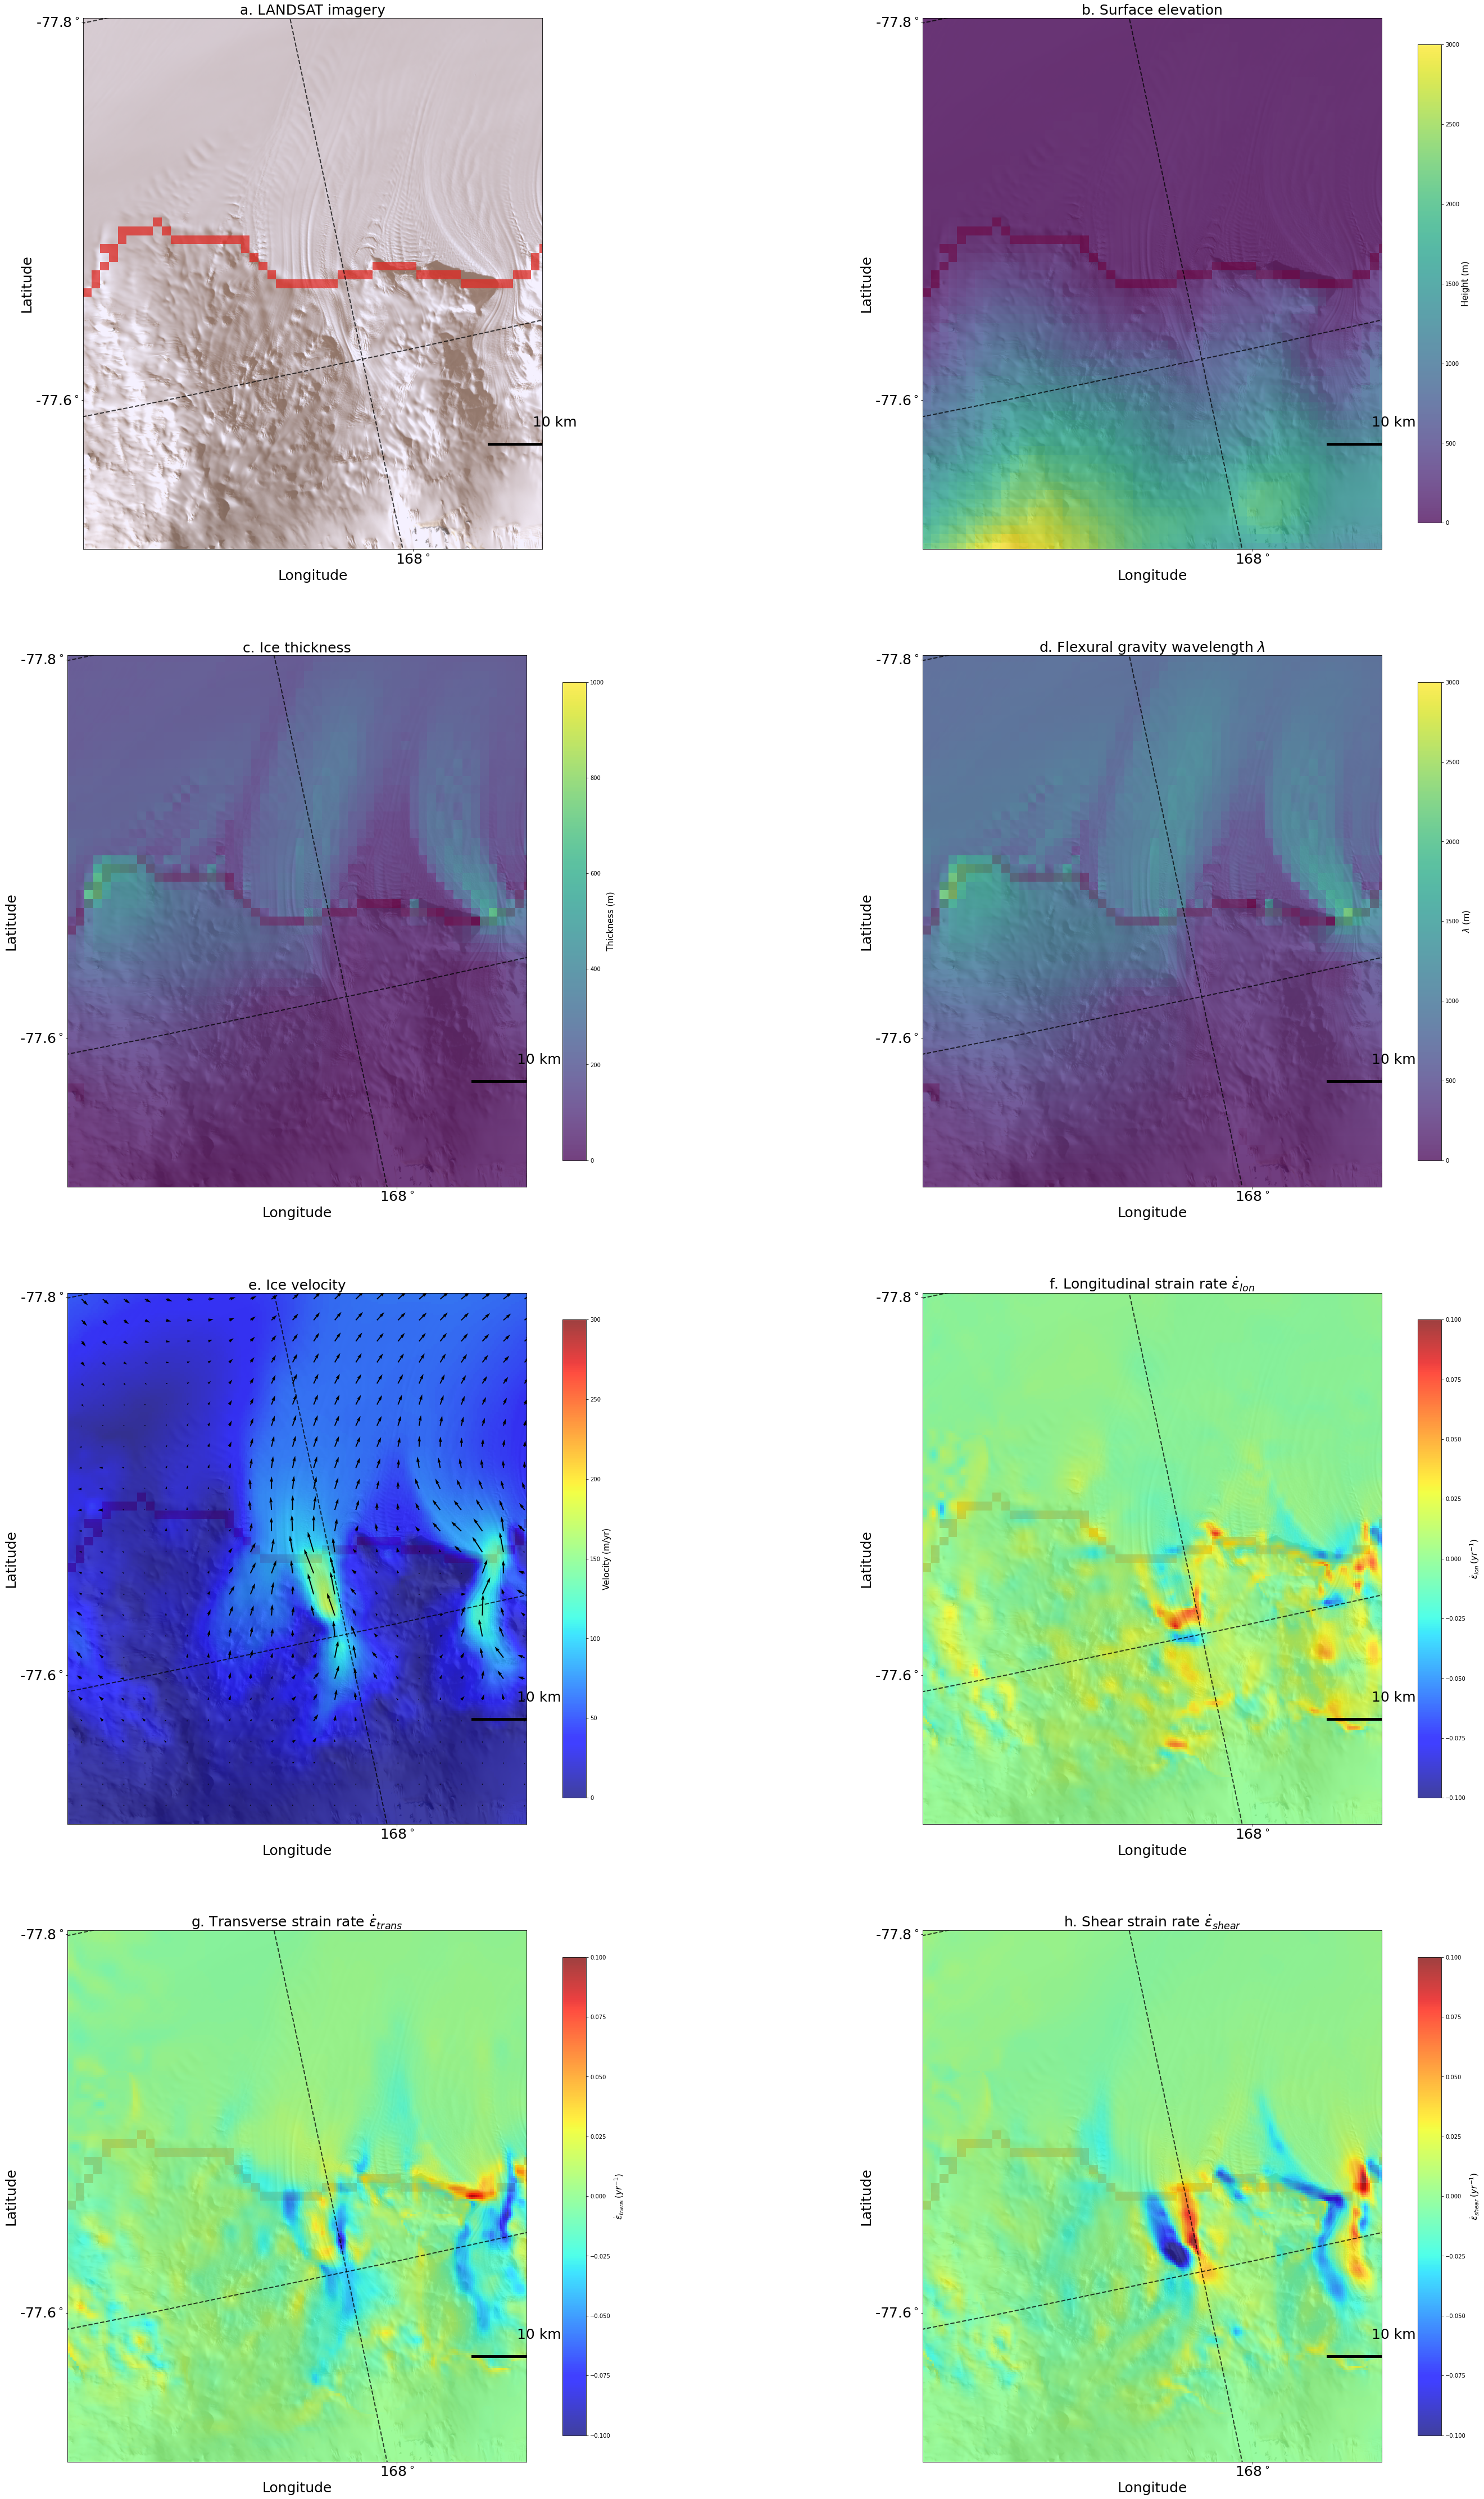

In [62]:
# make big plot showing each variable of interest
fig,ax = plt.subplots(4,2,figsize=(50,80))

# define zoomed bounds for plot
plot_bounds = [mcmurdo_left+12e4,mcmurdo_bottom+0.6e5,mcmurdo_right-10e4,mcmurdo_top-1.65e5]

# define, transform, and plot lat/lon grid on each panel
p1 = Proj(proj='latlong',preserve_units=False)
p2 = Proj("EPSG:3031",preserve_units=False)
lat = [-77.6,77.7,-77.8]
lon = [168,169]
x_label_pos=[]
y_label_pos=[]
line = np.linspace(120,180,100)
for i in lat:
    line_x,line_y = transform(p1,p2,line,np.linspace(i,i,100))
    [[ax[j][k].plot(line_x,line_y,linestyle='--',linewidth=2,c='k',alpha=0.75) for j in range(ax.shape[0])] for k in range(ax.shape[1])]
    y_label_pos.append(line_y[np.argmin(np.abs(line_x-plot_bounds[0]))])
line = np.linspace(-70,-90,100)
for i in lon:
    line_x,line_y = transform(p1,p2,np.linspace(i,i,100),line)
    [[ax[j][k].plot(line_x,line_y,linestyle='--',linewidth=2,c='k',alpha=0.75) for j in range(ax.shape[0])] for k in range(ax.shape[1])]
    x_label_pos.append(line_x[np.argmin(np.abs(line_y-plot_bounds[1]))])

# set ticks and labels for lat/lon grid on each panel
for j in range(ax.shape[0]):
     for k in range(ax.shape[1]):
        ax[j][k].set_xticks(x_label_pos)
        ax[j][k].set_xticklabels(labels=[str(l) + '$^\circ$' for l in lon],fontsize=25)
        ax[j][k].set_xlabel("Longitude",fontsize=25)
        ax[j][k].set_yticks(y_label_pos)
        ax[j][k].set_yticklabels(labels=[str(l) + '$^\circ$' for l in lat],fontsize=25)
        ax[j][k].set_ylabel("Latitude",fontsize=25)
        ax[j][k].set_xlim([plot_bounds[0],plot_bounds[2]])
        ax[j][k].set_ylim([plot_bounds[1],plot_bounds[3]])
        
# plot imagery for each panel
[[ax[i][j].imshow(normalized_rgb,extent=bounds) for i in range(ax.shape[0])] for j in range(ax.shape[1])]
    
# custom colormap for grounding line
ncolors = 175
color_array = plt.get_cmap('Reds')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0.75,ncolors)
map_object = LinearSegmentedColormap.from_list(name='gline',colors=color_array)
plt.register_cmap(cmap=map_object)
        
# plot grounding line for each panel
[[ax[i][j].pcolormesh(mask_mcmurdo['x'],mask_mcmurdo['y'],grounding_line,cmap="gline") for i in range(ax.shape[0])] for j in range(ax.shape[1])]
    
# first panel is just imagery with no grounding line
ax[0][0].imshow(normalized_rgb,extent=bounds)
ax[0][0].set_title("a. LANDSAT imagery",fontsize=25)
box = ax[0][0].get_position()

# plot surface elevation
ax[0][1].imshow(normalized_rgb,extent=bounds)
thick = ax[0][1].pcolormesh(elevation_mcmurdo['x'],elevation_mcmurdo['y'],elevation_mcmurdo,alpha=0.75,vmin=0,vmax=3000,cmap="viridis")    
ax[0][1].set_title("b. Surface elevation",fontsize=25)
cbar = fig.colorbar(thick, ax=ax[0][1], location='right', shrink=0.9)
cbar.set_label('Height (m)',fontsize=15)
        
# plot ice thickness
ax[1][0].imshow(normalized_rgb,extent=bounds)
thick = ax[1][0].pcolormesh(thickness_mcmurdo['x'],thickness_mcmurdo['y'],thickness_mcmurdo,alpha=0.75,vmin=0,vmax=1000,cmap="viridis")    
ax[1][0].set_title("c. Ice thickness",fontsize=25)
cbar = fig.colorbar(thick, ax=ax[1][0], location='right', shrink=0.9)
cbar.set_label('Thickness (m)',fontsize=15)
    
# plot flexural gravity wavelength
ax[1][1].imshow(normalized_rgb,extent=bounds)
thick = ax[1][1].pcolormesh(thickness_mcmurdo['x'],thickness_mcmurdo['y'],fgl,alpha=0.75,vmin=0,vmax=3000,cmap="viridis")    
ax[1][1].set_title("d. Flexural gravity wavelength $\lambda$",fontsize=25)
cbar = fig.colorbar(thick, ax=ax[1][1], location='right', shrink=0.9)
cbar.set_label('$\lambda$ (m)',fontsize=15)
    
# plot ice velocity
ax[2][0].imshow(normalized_rgb,extent=bounds)
vel = ax[2][0].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],vv_mcmurdo,alpha=0.75,vmin=0,vmax=300,cmap="jet")    
ax[2][0].quiver(x_v[::10],y_v[::10], vx_mcmurdo[::10,::10], vy_mcmurdo[::10,::10],units='xy',scale=0.1)
ax[2][0].set_title("e. Ice velocity",fontsize=25)
cbar = fig.colorbar(vel, ax=ax[2][0], location='right', shrink=0.9)
cbar.set_label('Velocity (m/yr)',fontsize=15)

# # plot strain rates (e_xx)
# ax[1][1].imshow(normalized_rgb,extent=bounds)
# xx = ax[1][1].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_xx,alpha=0.75,vmin=-10,vmax=10,cmap="jet")    
# ax[1][1].set_title("d. Strain rate $\dot{\epsilon}_{xx}$",fontsize=25)
# cbar = fig.colorbar(xx, ax=ax[1][1], location='right', shrink=0.7)
# cbar.set_label('$\dot{\epsilon}_{xx}\: (s^{-1})$',fontsize=15)

# # plot strain rates (e_yy)
# ax[2][0].imshow(normalized_rgb,extent=bounds)
# yy = ax[2][0].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_yy,alpha=0.75,vmin=-10,vmax=10,cmap="jet")    
# ax[2][0].set_title("e. Strain rate $\dot{\epsilon}_{yy}$",fontsize=25)
# cbar = fig.colorbar(yy, ax=ax[2][0], location='right', shrink=0.7)
# cbar.set_label('$\dot{\epsilon}_{yy}\: (s^{-1})$',fontsize=15)

# # plot strain rates (e_xy)
# ax[2][1].imshow(normalized_rgb,extent=bounds)
# xy = ax[2][1].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_xy,alpha=0.75,vmin=-10,vmax=10,cmap="jet")    
# ax[2][1].set_title("f. Strain rate $\dot{\epsilon}_{xy}$",fontsize=25)
# cbar = fig.colorbar(xy, ax=ax[2][1], location='right', shrink=0.7)
# cbar.set_label('$\dot{\epsilon}_{xy}\: (s^{-1})$',fontsize=15)

# plot longitudinal strain rates
ax[2][1].imshow(normalized_rgb,extent=bounds)
xx = ax[2][1].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_lon,alpha=0.75,vmin=-0.1,vmax=0.1,cmap="jet")    
ax[2][1].set_title("f. Longitudinal strain rate $\dot{\epsilon}_{lon}$",fontsize=25)
cbar = fig.colorbar(xx, ax=ax[2][1], location='right', shrink=0.9)
cbar.set_label('$\dot{\epsilon}_{lon}\: (yr^{-1})$',fontsize=15)

# plot transverse strain rates
ax[3][0].imshow(normalized_rgb,extent=bounds)
yy = ax[3][0].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_trans,alpha=0.75,vmin=-0.1,vmax=0.1,cmap="jet")    
ax[3][0].set_title("g. Transverse strain rate $\dot{\epsilon}_{trans}$",fontsize=25)
cbar = fig.colorbar(yy, ax=ax[3][0], location='right', shrink=0.9)
cbar.set_label('$\dot{\epsilon}_{trans}\: (yr^{-1})$',fontsize=15)

# plot shear strain rates
ax[3][1].imshow(normalized_rgb,extent=bounds)
xy = ax[3][1].pcolormesh(vv_mcmurdo['x'],vv_mcmurdo['y'],e_shear,alpha=0.75,vmin=-0.1,vmax=0.1,cmap="jet")    
ax[3][1].set_title("h. Shear strain rate $\dot{\epsilon}_{shear}$",fontsize=25)
cbar = fig.colorbar(xy, ax=ax[3][1], location='right', shrink=0.9)
cbar.set_label('$\dot{\epsilon}_{shear}\: (yr^{-1})$',fontsize=15)

# add a scale bar to each subset
[[ax[i][j].plot([plot_bounds[0]+(plot_bounds[2]-plot_bounds[0])/2+10000,plot_bounds[0]+(plot_bounds[2]-plot_bounds[0])/2+20000],[plot_bounds[1]+6000,plot_bounds[1]+6000],color='k',linewidth = 5) for i in range(ax.shape[0])] for j in range(ax.shape[1])]
[[ax[i][j].text(plot_bounds[0]+(plot_bounds[2]-plot_bounds[0])/2+12500,plot_bounds[1]+7000,"10 km",color='k',fontsize=25) for i in range(ax.shape[0])] for j in range(ax.shape[1])]

# save the plot
plt.savefig('mcmurdo_maps.png')

In [ ]:
# example of the god-awful griddata
#quiver_x,quiver_y = np.mgrid[mcmurdo_left:mcmurdo_right:100,mcmurdo_bottom:mcmurdo_top:100]
#quiver_x,quiver_y = np.meshgrid(quiver_x,quiver_y)
#quiver_vx = griddata(np.vstack((x_mesh.flatten(),y_mesh.flatten())).T, vx_mcmurdo.data.flatten(), (quiver_x, quiver_y), method='nearest')
#quiver_vy = griddata(np.vstack((x_mesh.flatten(),y_mesh.flatten())).T, vy_mcmurdo.data.flatten(), (quiver_x, quiver_y), method='nearest')        